## Autonomous_Mobile_Robotics Segmentation task 1
* Usage

Run the cell below to see the performance of clustering on one frame. 

For visualization, the first graph is the DBSCAN clustering result with ground points and noises labeled as blue points, the second graph is the result with ground poitns and noises filtered. The axis-aligned and oriented bounding boxes could be seen in the output cell.

Each function has multiple implemented methods as alternative parameters. Functions' manuals are also available.



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Estimated number of clusters: 110
Estimated number of noise points: 149


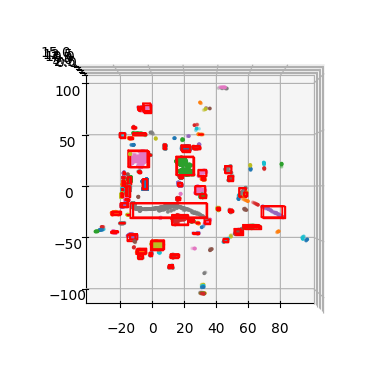

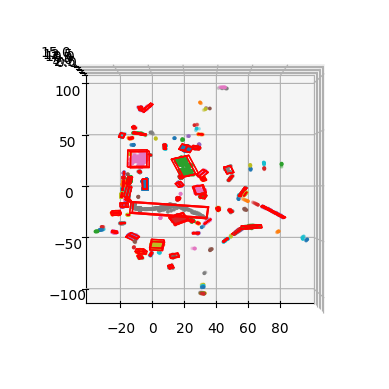

In [1]:
import math
import random
import json
import numpy as np 
import open3d as o3d
import sklearn.cluster
from sklearn import metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import art3d

def ground_segmentation(points, method= 'brutal'): # Options: 'brutal', 'RANSAC'
    ''' Segment the ground points from the point cloud
    
    Parameters
    ----------
    
    `points` (`numpy.ndarray`): point cloud to be segmented 
      
    `method` (`string`): method used. Options: `'RANSAC'`, `'brutal'`

    Returns
    -------
    `ground_cloud` (`numpy.ndarray`): ground point cloud
    `segmented_cloud` (`numpy.ndarray`): segmented point cloud without ground points
    `idx_ground` (`list`): index of round point cloud
    `idx_segmented` (`list`): index of ground point cloud
    '''
    if method == 'RANSAC':
        #Initialization
        idx_segmented = []
        segmented_cloud = []
        iters = 100   #Max iterations
        sigma = 0.4     #Max acceptable difference value between the data and the model 
        ##Parameter estimation and inlier counting   the plane function: aX + bY + cZ +D= 0
        best_a = 0
        best_b = 0
        best_c = 0
        best_d = 0
        pretotal = 0 # number of inliers previously
        #Probability of the correct model
        P = 0.99
        n = len(points)       # number of points
        outline_ratio = 0.6   # outlier_ratio
        for i in range(iters):
            ground_cloud = []
            idx_ground = []
            #step1 Choose the minimum dataset that could estimate the model. For plane fitting, 3
            sample_index = random.sample(range(n),3)
            point1 = points[sample_index[0]]
            point2 = points[sample_index[1]]
            point3 = points[sample_index[2]]
            #step2 Solve the model
            ## Derive the normal vector
            point1_2 = (point1-point2)      # Vector point1 -> point2
            point1_3 = (point1-point3)      # Vector point1 -> point3
            N = np.cross(point1_3,point1_2)            # Cross product of vetors to solve the plane normal vector
            ## Solve model parameters
            a = N[0]
            b = N[1]
            c = N[2]
            d = -N.dot(point1)
            #step3 Apply the data to the model, calculate the inliers
            total_inlier = 0
            pointn_1 = (points - point1)    # Vector constructed by points out of sample and one in the sample
            distance = abs(pointn_1.dot(N))/ np.linalg.norm(N)     #Distance calculation
            ## Judge the inliers
            idx_ground = (distance <= sigma)
            total_inlier = np.sum(idx_ground == True)   
            ## Judge if current model is better
            if total_inlier > pretotal:                                           #     log(1 - p)
                iters = math.log(1 - P) / math.log(1 - pow(total_inlier / n, 3))  #N = ------------
                pretotal = total_inlier                                               #log(1-[(1-e)**s])
                # Obtain the best parameters
                best_a = a
                best_b = b
                best_c = c
                best_d = d

            # Judge if the current model matches
            if total_inlier > n*(1-outline_ratio):
                break
        print("iters = %f" %iters)
        # Extract the points after segmentation
        idx_segmented = np.logical_not(idx_ground)
        ground_cloud = points[idx_ground]
        segmented_cloud = points[idx_segmented]
        return ground_cloud,segmented_cloud,idx_ground,idx_segmented

    if method == 'brutal':
        idx_ground = []
        idx_segmented = []
        for i in range(len(points)):
            if(points[i][2] >= 0.00000001):
                idx_segmented.append(i)
            else:
                idx_ground.append(i)
        ground_cloud = points[idx_ground]
        segmented_cloud = points[idx_segmented]
        return ground_cloud,segmented_cloud,idx_ground,idx_segmented

def clustering(points, method= 'dbscan'): # Options: 'dbscan', 'kmeans', 'optics', 'meanshift', 'AgglomerativeClustering', 'birch'
    ''' Perform clustering to the points using the method given
    
    Parameters
    ----------
    
    `points` (`numpy.ndarray`): point cloud to be clustered

    `method` (`string`): method used. Options: `'dbscan'`, `'kmeans'`, `'optics'`, `'meanshift'`, `'AgglomerativeClustering'`, `'birch'`

    Returns
    -------
    `labels` (`numpy.ndarray`): labels of each point
    '''
    if method == 'dbscan':
        db = sklearn.cluster.DBSCAN(eps=2,min_samples=3).fit(points)#eps=1.8, min_samples=20
        labels_db = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        n_noise_ = list(labels_db).count(-1)
        print("Estimated number of clusters: %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)
        return labels_db

    if method == 'kmeans':
        kmeans = sklearn.cluster.KMeans(n_clusters=70, random_state=0, n_init="auto").fit(points)
        labels_km = kmeans.labels_
        labels_unique = np.unique(labels_km)
        n_clusters_ = len(labels_unique)
        print("number of estimated clusters : %d" % n_clusters_)
        return labels_km

    if method == 'meanshift':
        # The following bandwidth can be automatically detected using
        bandwidth = sklearn.cluster.estimate_bandwidth(points, quantile=0.1, n_samples=500)

        ms = sklearn.cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(points)
        labels_ms = ms.labels_
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(labels_ms)
        n_clusters_ = len(labels_unique)

        print("number of estimated clusters : %d" % n_clusters_)
        return labels_ms

    if method == 'optics':
        clust = sklearn.cluster.OPTICS(min_samples=6)

        # Run the fit
        clust.fit(points)
        labels_op = clust.labels_[clust.ordering_]
        labels_unique = np.unique(labels_op)
        n_clusters_ = len(labels_unique)
        print("number of estimated clusters : %d" % n_clusters_)
        return labels_op

    if method == 'AgglomerativeClustering':
        clustering = sklearn.cluster.AgglomerativeClustering(70).fit(points)
        labels_unique = np.unique(clustering.labels_)
        n_clusters_ = len(labels_unique)
        print("number of estimated clusters : %d" % n_clusters_)
        return clustering.labels_

    if method == 'birch':
        brc = sklearn.cluster.Birch(n_clusters=65).fit(points)
        labels_brc = brc.predict(points)
        labels_unique = np.unique(labels_brc)
        n_clusters_ = len(labels_unique)
        print("number of estimated clusters : %d" % n_clusters_)
        return labels_brc

def ExtractBBox(points, labels, method= 'oriented'): # Options: 'axisAligned', 'oriented'
    ''' Extract the axis-aligned or oriented bounding boxes from clustered point cloud
    
    Parameters
    ----------
    
    `points` (`numpy.ndarray`): nx3 clustered point cloud
      
    `method` (`string`): method used. Options: `'axisAligned'`, `'oriented'`

    Returns
    -------
    `bboxes` (`numpy.ndarray`): list of bounding boxes
    '''
    if method == 'oriented':
        bboxes = []
        sortedLabels = np.unique(labels)
        for label in sortedLabels:
            cluster = []
            for i in range(len(labels)):
                if labels[i] == label:
                    cluster.append(points[i])
            if len(cluster) < 7:   #Noise removal
                continue
            cluster = np.array(cluster)
            cluster = o3d.utility.Vector3dVector(cluster)
            bbox = o3d.geometry.OrientedBoundingBox()
            bbox = bbox.create_from_points(cluster)
            bbox = np.asarray(bbox.get_box_points())
            bbox = np.array([bbox[3],bbox[6],bbox[1],bbox[0],bbox[5],bbox[4],bbox[7],bbox[2]])
            bboxes.append(bbox)
        bboxes = np.array(bboxes)
        return bboxes

    if method == 'axisAlighed':
        bboxes = []
        for label in np.unique(labels):
            cluster = points[label == labels,:]
            if len(cluster) < 7:   #Noise removal
                continue
            x_min, x_max = np.min(cluster[:, 0]), np.max(cluster[:, 0])
            y_min, y_max = np.min(cluster[:, 1]), np.max(cluster[:, 1])
            z_min, z_max = np.min(cluster[:, 2]), np.max(cluster[:, 2])
            bbox = np.array([[x_min,y_min,z_min],
                            [x_max,y_min,z_min],
                            [x_max,y_max,z_min],
                            [x_min,y_max,z_min],
                            [x_min,y_min,z_max],
                            [x_max,y_min,z_max],
                            [x_max,y_max,z_max],
                            [x_min,y_max,z_max]])
            bboxes.append(bbox)
        bboxes = np.array(bboxes)
        return bboxes

def vis(points, labels, bboxes, method= 'plt'): #Options: 'plt', 'open3d'
    ''' Visulize the point cloud and bounding boxes in open3d UI or matplotlib UI
    
    Parameters
    ----------
    
    `points` (`numpy.ndarray`): nx3 point cloud
      
    `method` (`string`): method used. Options: `'o3d'`, `'plt'`

    Returns
    -------
    Visualization
    '''
    if method == 'o3d':
        labels=np.asarray(labels)
        max_label=labels.max()

        # 颜色
        colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
        pt1 = o3d.geometry.PointCloud()
        pt1.points = o3d.utility.Vector3dVector(points.reshape(-1, 3))
        pt1.colors=o3d.utility.Vector3dVector(colors[:, :3])

        o3d.visualization.draw_geometries([pt1],'part of cloud',width=500,height=500)
    if method == 'plt':
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for label in np.unique(labels):
            ax.scatter(points[:,0:3][label == labels, 0], 
                    points[:,0:3][label == labels, 1], 
                    points[:,0:3][label == labels, 2],
                    s = 3,
                    )
        for bbox in bboxes:
            verts = [[bbox[0],bbox[1],bbox[2],bbox[3]],
            [bbox[4],bbox[5],bbox[6],bbox[7]],
            [bbox[0],bbox[1],bbox[5],bbox[4]],
            [bbox[2],bbox[3],bbox[7],bbox[6]],
            [bbox[1],bbox[2],bbox[6],bbox[5]],
            [bbox[4],bbox[7],bbox[3],bbox[0]]]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=[0,0,0,0], linewidths=1, edgecolors='r'))
        ax.view_init(elev=90, azim=-90)
        plt.show()

def main():
    file_data = np.fromfile('lidar_data/frame3.pcd.bin', dtype=np.float32)
    points = file_data.reshape((-1, 5))[:, :4]

    x = points[:, 0]  # x position of point
    y = points[:, 1]  # y position of point
    z = points[:, 2]  # z position of point
    r = points[:, 3]  # reflectance value of point
    d = np.sqrt(x ** 2 + y ** 2)  # Map Distance from sensor
    degr = np.degrees(np.arctan(z / d))
    # vals = 'height'
    # if vals == "height":
    #     col = z
    # else:
    #     col = d
    # Points: (x, y, z, intensity)

    #Ground segmentation
    ground_cloud,segmented_cloud, index_ground, index_segmented = ground_segmentation(points[:,0:3],'brutal')
    x = points[:, 0]  # x position of point
    y = points[:, 1]  # y position of point
    z = points[:, 2]  # z position of point
    r = points[:, 3]  # reflectance value of point
    d = np.sqrt(x ** 2 + y ** 2)  # Map Distance from sensor
    degr = np.degrees(np.arctan(z / d))
    # vals = 'height'
    # if vals == "height":

    #Clustering
    labels = clustering(segmented_cloud, method= 'dbscan') # Options: 'dbscan', 'kmeans', 'optics', 'meanshift', 'agglomerative', 'birch'
    labels += 1
    #Add labels to the whole pointcloud
    points = np.insert(points,4,0,axis = 1)
    points[index_ground, 4] = 1
    points[index_segmented, 4] = labels
    #Add labels to the segmented pointcloud
    segmented_cloud = np.insert(segmented_cloud,3,0,axis = 1)
    segmented_cloud[:,3] = labels
    #Noise removal
    points = points[points[:,4] > 0]
    segmented_cloud = segmented_cloud[segmented_cloud[:,3] > 0]

    #Bounding Box Extraction
    axis_aligned_bboxes = ExtractBBox(segmented_cloud[:,0:3], segmented_cloud[:,3],'axisAlighed')
    oriented_bboxes = ExtractBBox(segmented_cloud[:,0:3], segmented_cloud[:,3],'oriented')

    #Visualization
    vis(points[:,0:3],points[:,4],axis_aligned_bboxes,method='o3d')# With ground points and noises
    vis(segmented_cloud[:,0:3],segmented_cloud[:,3],axis_aligned_bboxes,method='o3d')# Without ground points and noises
    vis(segmented_cloud[:,0:3],segmented_cloud[:,3],axis_aligned_bboxes,method='plt')# With axis aligned bounding boxes
    vis(segmented_cloud[:,0:3],segmented_cloud[:,3],oriented_bboxes,method='plt')# With oriented bounding boxes

    #Data saving
    data = {}
    for i in range(len(oriented_bboxes)):
        bbox = oriented_bboxes[i].tolist()
        data[f'cluster {i}'] = bbox

    with open('lidar_clustering.json', 'w') as f:
        json.dump(data, f)

if __name__ == '__main__':
    main()

The below cell is used to create the clustering results as .json files in a batch. The visualization functions are commented for convenience. The format of the results is a dictionary.

{cluster i (*string*) : bboxes (*Union[AxisAlignedBoundingBox, OrientedBoundingBox]* )}

In [8]:
import os
import math
import random
import json
import numpy as np 
import open3d as o3d
import sklearn.cluster
from sklearn import metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import art3d

def ground_segmentation(points, method='brutal'):
    ''' Segment the ground points from the point cloud
    
    Parameters
    ----------
    
    `points` (`numpy.ndarray`): point cloud to be segmented 
      
    `method` (`string`): method used. Options: `'RANSAC'`, `'brutal'`

    Returns
    -------
    `ground_cloud` (`numpy.ndarray`): ground point cloud
    `segmented_cloud` (`numpy.ndarray`): segmented point cloud without ground points
    `idx_ground` (`list`): index of round point cloud
    `idx_segmented` (`list`): index of ground point cloud
    '''
    if method == 'RANSAC':
        # 屏蔽开始
        #初始化数据
        idx_segmented = []
        segmented_cloud = []
        iters = 100   #最大迭代次数  000002.bin：10
        sigma = 0.4     #数据和模型之间可接受的最大差值   000002.bin：0.5   000001.bin: 0.2  000000.bin: 0.15  002979.bin：0.15  004443.bin：0.4
        ##最好模型的参数估计和内点数目,平面表达方程为   aX + bY + cZ +D= 0
        best_a = 0
        best_b = 0
        best_c = 0
        best_d = 0
        pretotal = 0 #上一次inline的点数
        #希望的到正确模型的概率
        P = 0.99
        n = len(points)    #点的数目
        outline_ratio = 0.6   #e :outline_ratio   000002.bin：0.6    000001.bin: 0.5  000000.bin: 0.6   002979.bin：0.6
        for i in range(iters):
            ground_cloud = []
            idx_ground = []
            #step1 选择可以估计出模型的最小数据集，对于平面拟合来说，就是三个点
            sample_index = random.sample(range(n),3)    #重数据集中随机选取3个点
            point1 = points[sample_index[0]]
            point2 = points[sample_index[1]]
            point3 = points[sample_index[2]]
            #step2 求解模型
            ##先求解法向量
            point1_2 = (point1-point2)      #向量 poin1 -> point2
            point1_3 = (point1-point3)      #向量 poin1 -> point3
            N = np.cross(point1_3,point1_2)            #向量叉乘求解 平面法向量
            ##slove model 求解模型的a,b,c,d
            a = N[0]
            b = N[1]
            c = N[2]
            d = -N.dot(point1)
            #step3 将所有数据带入模型，计算出“内点”的数目；(累加在一定误差范围内的适合当前迭代推出模型的数据)
            total_inlier = 0
            pointn_1 = (points - point1)    #sample（三点）外的点 与 sample内的三点其中一点 所构成的向量
            distance = abs(pointn_1.dot(N))/ np.linalg.norm(N)     #求距离
            ##使用距离判断inline
            idx_ground = (distance <= sigma)
            total_inlier = np.sum(idx_ground == True)    #统计inline得点数
            ##判断当前的模型是否比之前估算的模型
            if total_inlier > pretotal:                                           #     log(1 - p)
                iters = math.log(1 - P) / math.log(1 - pow(total_inlier / n, 3))  #N = ------------
                pretotal = total_inlier                                               #log(1-[(1-e)**s])
                #获取最好得 abcd 模型参数
                best_a = a
                best_b = b
                best_c = c
                best_d = d

            # 判断是否当前模型已经符合超过 inline_ratio
            if total_inlier > n*(1-outline_ratio):
                break
        print("iters = %f" %iters)
        #提取分割后得点
        idx_segmented = np.logical_not(idx_ground)
        ground_cloud = points[idx_ground]
        segmented_cloud = points[idx_segmented]
        return ground_cloud,segmented_cloud,idx_ground,idx_segmented

    if method == 'brutal':
        idx_ground = []
        idx_segmented = []
        for i in range(len(points)):
            if(points[i][2] >= 0.00000001):
                idx_segmented.append(i)
            else:
                idx_ground.append(i)
        ground_cloud = points[idx_ground]
        segmented_cloud = points[idx_segmented]
        return ground_cloud,segmented_cloud,idx_ground,idx_segmented

def clustering(points, method='dbscan'):
    ''' Perform clustering to the points using the method given
    
    Parameters
    ----------
    
    `points` (`numpy.ndarray`): point cloud to be clustered

    `method` (`string`): method used. Options: `'dbscan'`, `'kmeans'`, `'optics'`, `'meanshift'`, `'AgglomerativeClustering'`, `'birch'`

    Returns
    -------
    `labels` (`numpy.ndarray`): labels of each point
    '''
    if method == 'dbscan':
        db = sklearn.cluster.DBSCAN(eps=2,min_samples=3).fit(points)#eps=1.8, min_samples=20
        labels_db = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        n_noise_ = list(labels_db).count(-1)
        print("Estimated number of clusters: %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)
        return labels_db

    if method == 'kmeans':
        kmeans = sklearn.cluster.KMeans(n_clusters=70, random_state=0, n_init="auto").fit(points)
        labels_km = kmeans.labels_
        labels_unique = np.unique(labels_km)
        n_clusters_ = len(labels_unique)
        print("number of estimated clusters : %d" % n_clusters_)
        return labels_km

    if method == 'meanshift':
        # The following bandwidth can be automatically detected using
        bandwidth = sklearn.cluster.estimate_bandwidth(points, quantile=0.1, n_samples=500)

        ms = sklearn.cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(points)
        labels_ms = ms.labels_
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(labels_ms)
        n_clusters_ = len(labels_unique)

        print("number of estimated clusters : %d" % n_clusters_)
        return labels_ms

    if method == 'optics':
        clust = sklearn.cluster.OPTICS(min_samples=6)

        # Run the fit
        clust.fit(points)
        labels_op = clust.labels_[clust.ordering_]
        labels_unique = np.unique(labels_op)
        n_clusters_ = len(labels_unique)
        print("number of estimated clusters : %d" % n_clusters_)
        return labels_op

    if method == 'AgglomerativeClustering':
        clustering = sklearn.cluster.AgglomerativeClustering(70).fit(points)
        labels_unique = np.unique(clustering.labels_)
        n_clusters_ = len(labels_unique)
        print("number of estimated clusters : %d" % n_clusters_)
        return clustering.labels_

    if method == 'birch':
        brc = sklearn.cluster.Birch(n_clusters=65).fit(points)
        labels_brc = brc.predict(points)
        labels_unique = np.unique(labels_brc)
        n_clusters_ = len(labels_unique)
        print("number of estimated clusters : %d" % n_clusters_)
        return labels_brc

def ExtractBBox(points,labels,method='oriented'):
    ''' Extract the axis-aligned or oriented bounding boxes from clustered point cloud
    
    Parameters
    ----------
    
    `points` (`numpy.ndarray`): nx3 clustered point cloud
      
    `method` (`string`): method used. Options: `'axisAligned'`, `'oriented'`

    Returns
    -------
    `bboxes` (`numpy.ndarray`): list of bounding boxes
    '''
    if method == 'oriented':
        bboxes = []
        sortedLabels = np.unique(labels)
        for label in sortedLabels:
            cluster = []
            for i in range(len(labels)):
                if labels[i] == label:
                    cluster.append(points[i])
            if len(cluster) < 7:   #Noise removal
                continue
            cluster = np.array(cluster)
            cluster = o3d.utility.Vector3dVector(cluster)
            bbox = o3d.geometry.OrientedBoundingBox()
            bbox = bbox.create_from_points(cluster)
            bbox = np.asarray(bbox.get_box_points())
            bbox = np.array([bbox[3],bbox[6],bbox[1],bbox[0],bbox[5],bbox[4],bbox[7],bbox[2]])
            bboxes.append(bbox)
        bboxes = np.array(bboxes)
        return bboxes

    if method == 'axisAlighed':
        bboxes = []
        for label in np.unique(labels):
            cluster = points[label == labels,:]
            if len(cluster) < 7:   #Noise removal
                continue
            x_min, x_max = np.min(cluster[:, 0]), np.max(cluster[:, 0])
            y_min, y_max = np.min(cluster[:, 1]), np.max(cluster[:, 1])
            z_min, z_max = np.min(cluster[:, 2]), np.max(cluster[:, 2])
            bbox = np.array([[x_min,y_min,z_min],
                            [x_max,y_min,z_min],
                            [x_max,y_max,z_min],
                            [x_min,y_max,z_min],
                            [x_min,y_min,z_max],
                            [x_max,y_min,z_max],
                            [x_max,y_max,z_max],
                            [x_min,y_max,z_max]])
            bboxes.append(bbox)
        bboxes = np.array(bboxes)
        return bboxes

def vis(points,labels,bboxes,method='plt'):
    ''' Visulize the point cloud and bounding boxes in open3d UI or matplotlib UI
    
    Parameters
    ----------
    
    `points` (`numpy.ndarray`): nx3 point cloud
      
    `method` (`string`): method used. Options: `'o3d'`, `'plt'`

    Returns
    -------
    Visualization
    '''
    if method == 'o3d':
        labels=np.asarray(labels)
        max_label=labels.max()

        # 颜色
        colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
        pt1 = o3d.geometry.PointCloud()
        pt1.points = o3d.utility.Vector3dVector(points.reshape(-1, 3))
        pt1.colors=o3d.utility.Vector3dVector(colors[:, :3])

        o3d.visualization.draw_geometries([pt1],'part of cloud',width=500,height=500)
    if method == 'plt':
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for label in np.unique(labels):
            ax.scatter(points[:,0:3][label == labels, 0], 
                    points[:,0:3][label == labels, 1], 
                    points[:,0:3][label == labels, 2],
                    s = 3,
                    )
        for bbox in bboxes:
            verts = [[bbox[0],bbox[1],bbox[2],bbox[3]],
            [bbox[4],bbox[5],bbox[6],bbox[7]],
            [bbox[0],bbox[1],bbox[5],bbox[4]],
            [bbox[2],bbox[3],bbox[7],bbox[6]],
            [bbox[1],bbox[2],bbox[6],bbox[5]],
            [bbox[4],bbox[7],bbox[3],bbox[0]]]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=[0,0,0,0], linewidths=1, edgecolors='r'))
        ax.view_init(elev=90, azim=-90)
        plt.show()

def main():
    count = 0
    file_path = os.path.join(os.getcwd(), 'lidar_data/')
    # file_data = np.fromfile('/home/jidan/Documents/me5413/1_lidar/lidar_data/frame3.pcd.bin', dtype=np.float32)
    for file in os.listdir(file_path):
        count += 1
        file_name = file_path + file
        file_data = np.fromfile(file_name, dtype=np.float32)
        points = file_data.reshape((-1, 5))[:, :4]

        x = points[:, 0]  # x position of point
        y = points[:, 1]  # y position of point
        z = points[:, 2]  # z position of point
        r = points[:, 3]  # reflectance value of point
        d = np.sqrt(x ** 2 + y ** 2)  # Map Distance from sensor
        degr = np.degrees(np.arctan(z / d))
        # vals = 'height'
        # if vals == "height":
        #     col = z
        # else:
        #     col = d
        # Points: (x, y, z, intensity)

        #Ground segmentation
        ground_cloud,segmented_cloud, index_ground, index_segmented = ground_segmentation(points[:,0:3],'brutal')
        x = points[:, 0]  # x position of point
        y = points[:, 1]  # y position of point
        z = points[:, 2]  # z position of point
        r = points[:, 3]  # reflectance value of point
        d = np.sqrt(x ** 2 + y ** 2)  # Map Distance from sensor
        degr = np.degrees(np.arctan(z / d))
        # vals = 'height'
        # if vals == "height":

        #Clustering
        #Options: 'dbscan', 'kmeans', 'optics', 'meanshift', 'agglomerative', 'birch'
        labels = clustering(segmented_cloud, method='dbscan')
        labels += 1
        #Add labels to the whole pointcloud
        points = np.insert(points,4,0,axis = 1)
        points[index_ground, 4] = 1
        points[index_segmented, 4] = labels
        #Add labels to the segmented pointcloud
        segmented_cloud = np.insert(segmented_cloud,3,0,axis = 1)
        segmented_cloud[:,3] = labels
        #Noise removal
        points = points[points[:,4] > 0]
        segmented_cloud = segmented_cloud[segmented_cloud[:,3] > 0]

        #Bounding Box Extraction
        axis_aligned_bboxes = ExtractBBox(segmented_cloud[:,0:3], segmented_cloud[:,3],'axisAlighed')
        oriented_bboxes = ExtractBBox(segmented_cloud[:,0:3], segmented_cloud[:,3],'oriented')

        #Visualization
        # vis(points[:,0:3],points[:,4],axis_aligned_bboxes,method='o3d')#With ground points
        # vis(segmented_cloud[:,0:3],segmented_cloud[:,3],axis_aligned_bboxes,method='o3d')#Without ground points
        # vis(segmented_cloud[:,0:3],segmented_cloud[:,3],axis_aligned_bboxes,method='plt')#With axis aligned bounding boxes
        # vis(segmented_cloud[:,0:3],segmented_cloud[:,3],oriented_bboxes,method='plt')#With oriented bounding boxes

        #Data saving
        data = {}
        for i in range(len(oriented_bboxes)):
            bbox = oriented_bboxes[i].tolist()
            data[f'cluster {i}'] = bbox

        with open('clustering_results/lidar_clustering_' + str(count) + '.json', 'w') as f:
            json.dump(data, f)

if __name__ == '__main__':
    main()

Estimated number of clusters: 115
Estimated number of noise points: 170
Estimated number of clusters: 101
Estimated number of noise points: 180
Estimated number of clusters: 122
Estimated number of noise points: 148
Estimated number of clusters: 117
Estimated number of noise points: 176
Estimated number of clusters: 94
Estimated number of noise points: 157
Estimated number of clusters: 87
Estimated number of noise points: 157
Estimated number of clusters: 92
Estimated number of noise points: 157
Estimated number of clusters: 106
Estimated number of noise points: 155
Estimated number of clusters: 110
Estimated number of noise points: 149
Estimated number of clusters: 136
Estimated number of noise points: 125
